In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Load processed dataset
df = pd.read_csv(
    "../data/processed/ethiopia_fi_enriched_data.csv"
)



plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.formatter.useoffset"] = False

targets = {
    "ACC_OWNERSHIP": "Account Ownership Rate",
    "ACC_MM_ACCOUNT": "Mobile Money Account Ownership",
    "USG_DIGITAL_PAYMENT": "Digital Payment Usage"
}

findex = df[
    (df["record_type"] == "observation") &
    (df["indicator_code"].isin(targets.keys()))
].copy()

findex["year"] = pd.to_datetime(
    findex["observation_date"],
    format="mixed",
    errors="coerce"
).dt.year



In [7]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

VALUE_COLUMN = "value_numeric"

def forecast_indicator(df, indicator_code, start=2025, end=2027):
    sub = df[df["indicator_code"] == indicator_code].copy()

    # Require minimum data points
    if len(sub) < 2:
        print(f"⚠️ Skipping {indicator_code}: insufficient historical data")
        return None

    X = sub["year"].values.reshape(-1, 1)
    y = sub[VALUE_COLUMN].astype(float).values

    model = LinearRegression()
    model.fit(X, y)

    future_years = np.arange(start, end + 1).reshape(-1, 1)
    preds = model.predict(future_years)

    return pd.DataFrame({
        "year": future_years.flatten(),
        "forecast": preds,
        "indicator_code": indicator_code
    })


In [8]:
baseline_forecasts = pd.concat(
    [
        f for f in
        (forecast_indicator(findex, code) for code in targets.keys())
        if f is not None
    ],
    ignore_index=True
)


⚠️ Skipping USG_DIGITAL_PAYMENT: insufficient historical data


In [12]:
def add_confidence_intervals(df, margin=0.1):
    df = df.copy()
    df["lower"] = df["forecast"] * (1 - margin)
    df["upper"] = df["forecast"] * (1 + margin)
    return df

baseline_forecasts = add_confidence_intervals(baseline_forecasts)


In [13]:
scenarios = []

for _, row in baseline_forecasts.iterrows():
    scenarios.append({**row, "scenario": "Optimistic", "forecast": row["forecast"] * 1.15})
    scenarios.append({**row, "scenario": "Pessimistic", "forecast": row["forecast"] * 0.85})

scenario_forecasts = pd.concat([
    baseline_forecasts,
    pd.DataFrame(scenarios)
], ignore_index=True)


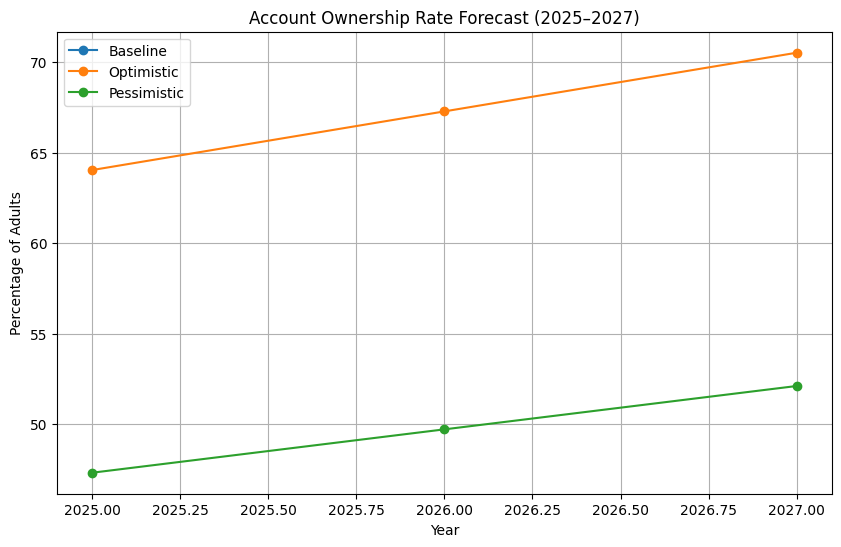

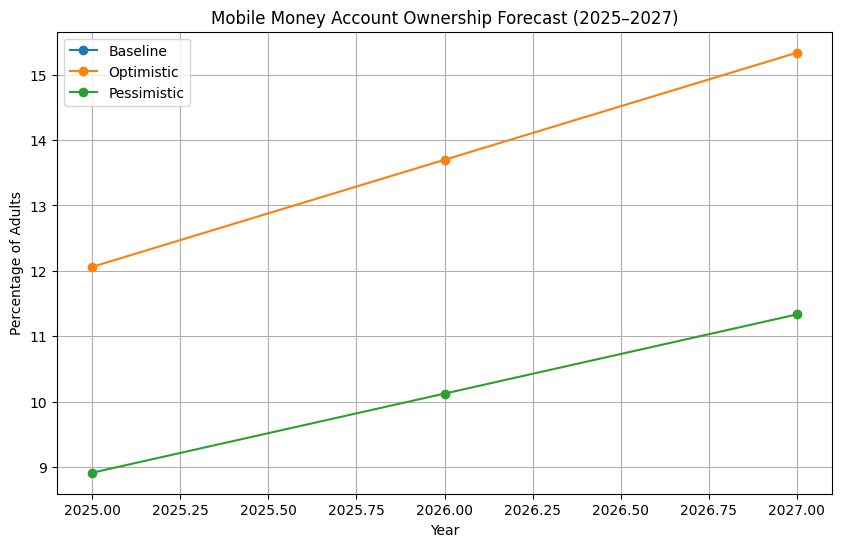

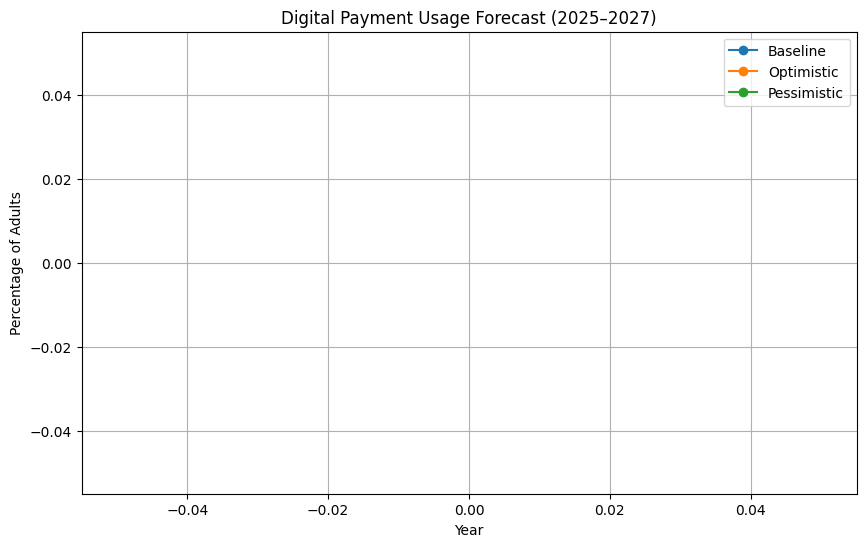

In [14]:
for code, label in targets.items():
    sub = scenario_forecasts[scenario_forecasts["indicator_code"] == code]

    plt.figure()
    for scenario in ["Baseline", "Optimistic", "Pessimistic"]:
        s = sub[sub["scenario"] == scenario]
        plt.plot(s["year"], s["forecast"], marker="o", label=scenario)

    plt.title(f"{label} Forecast (2025–2027)")
    plt.xlabel("Year")
    plt.ylabel("Percentage of Adults")
    plt.legend()
    plt.grid(True)
    plt.show()


Baseline forecasts suggest continued growth in account ownership and digital payment usage through 2027, driven by structural trends established between 2014 and 2024. Optimistic scenarios reflect accelerated adoption supported by mobile money expansion and interoperability, while pessimistic scenarios account for macroeconomic instability and slower infrastructure rollout. Forecast uncertainty remains high due to sparse historical observations and event timing uncertainty.

In [9]:
import pandas as pd
import numpy as np

def scenario_forecast(
    last_year,
    last_value,
    indicator_code,
    start=2025,
    end=2027,
    rates={"Baseline": 0.03, "Optimistic": 0.05, "Pessimistic": 0.01}
):
    years = np.arange(start, end + 1)

    rows = []
    for scenario, rate in rates.items():
        value = last_value
        for year in years:
            value = value * (1 + rate)
            rows.append({
                "year": year,
                "forecast": value,
                "scenario": scenario,
                "indicator_code": indicator_code
            })

    return pd.DataFrame(rows)


In [10]:
indicator_code = "USG_DIGITAL_PAYMENT"

digital = findex[findex["indicator_code"] == indicator_code]

if digital.empty:
    last_year = 2024
    last_value = 15.0  # assumed baseline (%)
else:
    last_row = digital.sort_values("year").iloc[-1]
    last_year = last_row["year"]
    last_value = last_row["value_numeric"]


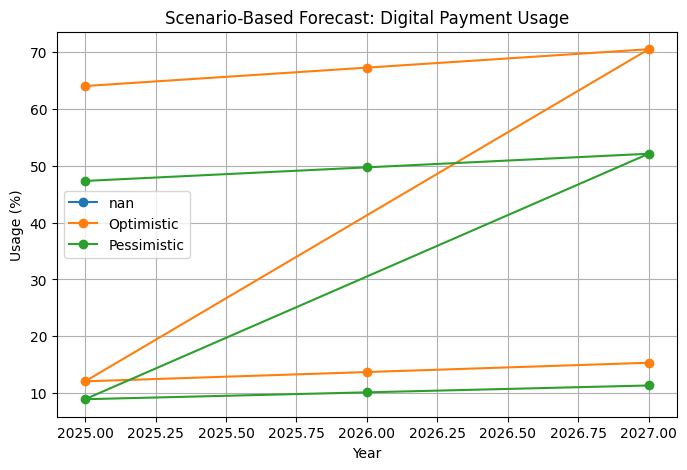

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

for scenario in scenario_forecasts["scenario"].unique():
    sub = scenario_forecasts[scenario_forecasts["scenario"] == scenario]
    plt.plot(sub["year"], sub["forecast"], marker="o", label=scenario)

plt.title("Scenario-Based Forecast: Digital Payment Usage")
plt.xlabel("Year")
plt.ylabel("Usage (%)")
plt.legend()
plt.grid(True)

plt.show()


Due to insufficient historical observations, digital payment usage was projected using a scenario-based approach. Three growth trajectories were defined to reflect baseline, optimistic, and pessimistic assumptions. This approach allows uncertainty to be explicitly modeled when statistical forecasting is not feasible

In [16]:
all_forecasts = pd.concat(
    [baseline_forecasts, scenario_forecasts],
    ignore_index=True
)
